# Simulating Requests to an AI Prediction Deployed Model



## Setup

In [1]:
import os
from tensorflow import io as tf_io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PROJECT = 'mlops-dev-env'
BUCKET =  'mlops-dev-workspace'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
LOCAL_WORKSPACE = './workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
LOCAL_DATA_FILE = os.path.join(LOCAL_DATA_DIR, 'train.csv')
BQ_DATASET_NAME = 'data_validation'
BQ_TABLE_NAME = 'covertype_classifier_logs_tf'
MODEL_NAME = 'covertype_classifier_tf'
VERSION_NAME = 'v2'
MODEL_OUTPUT_KEY = 'probabilities'
SIGNATURE_NAME = 'serving_default'

In [3]:
!gcloud config set project {PROJECT}

Updated property [core/project].


## 1. Download Data

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

In [4]:
if tf_io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf_io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf_io.gfile.makedirs(LOCAL_WORKSPACE)
tf_io.gfile.makedirs(LOCAL_DATA_DIR)

Creating a new workspace...


In [5]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_DATA_FILE}
!wc -l {LOCAL_DATA_FILE}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...
/ [1 files][ 22.2 MiB/ 22.2 MiB]                                                
Operation completed over 1 objects/22.2 MiB.                                     
431010 ./workspace/data/train.csv


In [6]:
import pandas as pd
data = pd.read_csv(LOCAL_DATA_FILE)
print("Total number of records: {}".format(len(data.index)))
data.sample(10).T

Total number of records: 431009


,142538,179198,417758,307904,308836,315787,388750,125211,315673,336480
Elevation,3225,2876,2563,3149,2827,2511,3184,3195,3029,3021
Aspect,148,119,2,91,22,167,157,194,104,0
Slope,10,10,14,11,10,31,2,10,20,9
Horizontal_Distance_To_Hydrology,150,361,95,30,150,323,390,108,30,228
Vertical_Distance_To_Hydrology,12,56,26,6,16,127,52,20,-8,24
Horizontal_Distance_To_Roadways,5825,2259,690,4654,1398,335,1146,3049,655,2659
Hillshade_9am,234,237,200,237,214,228,221,218,249,206
Hillshade_Noon,239,232,213,223,218,233,239,249,210,222
Hillshade_3pm,136,125,149,117,140,113,154,164,80,154
Horizontal_Distance_To_Fire_Points,1063,2736,408,2974,3004,972,1935,5126,778,832


## 2. Define Metadata

In [7]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURE_NAMES = ['Soil_Type', 'Wilderness_Area']

FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

#### create a container for the serving data

In [8]:
serving_data = {
    '2020-04-01': None,
    '2020-04-02': None,
    '2020-04-03': None,
    '2020-04-04': None,
    '2020-04-05': None,
    '2020-04-06': None,
}

## 3. Sampling Unskewed Data

* Sample data for *three* consecutive dates: **01-04-20202**, **02-04-2020**, and **03-04-2020**
* Each day has 1000 examples
* No altering is applied



In [9]:
data_normal = data.sample(3000)

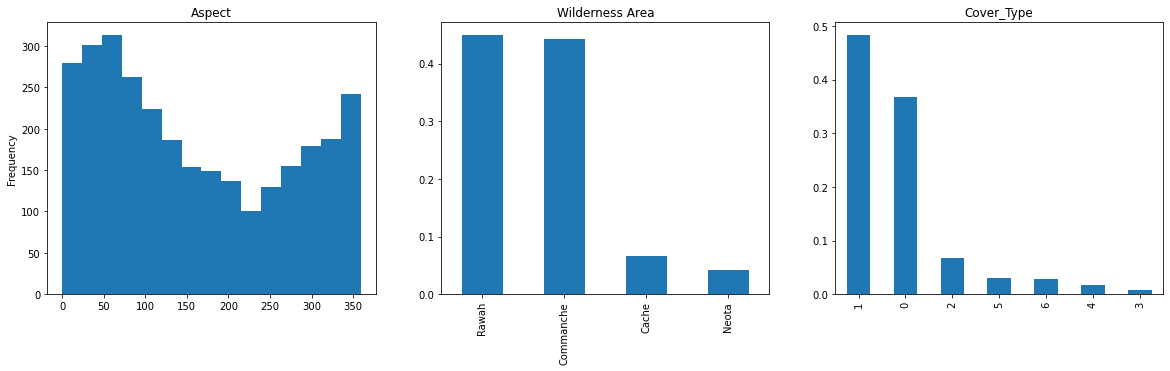

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
data_normal['Aspect'].plot.hist(bins=15, ax=axes[0], title='Aspect')
data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area')
data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[2], title=TARGET_FEATURE_NAME)

In [11]:
normal_days_data_list =[
                        data_normal[:1000],
                        data_normal[1000:2000],
                        data_normal[2000:]
]


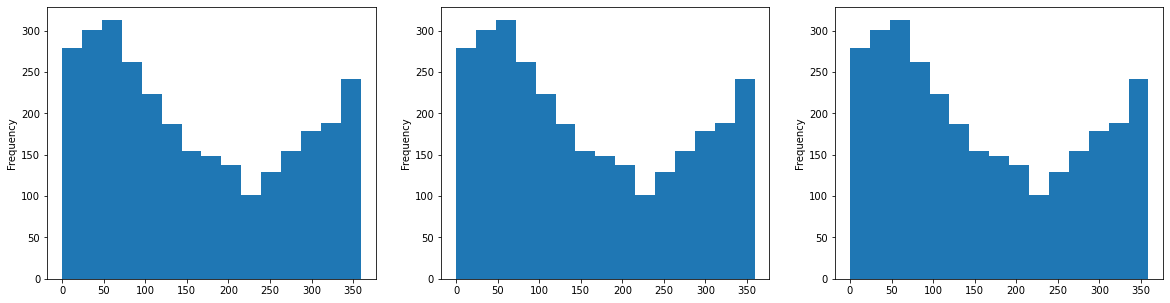

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Aspect'].plot.hist(bins=15, ax=axes[i])

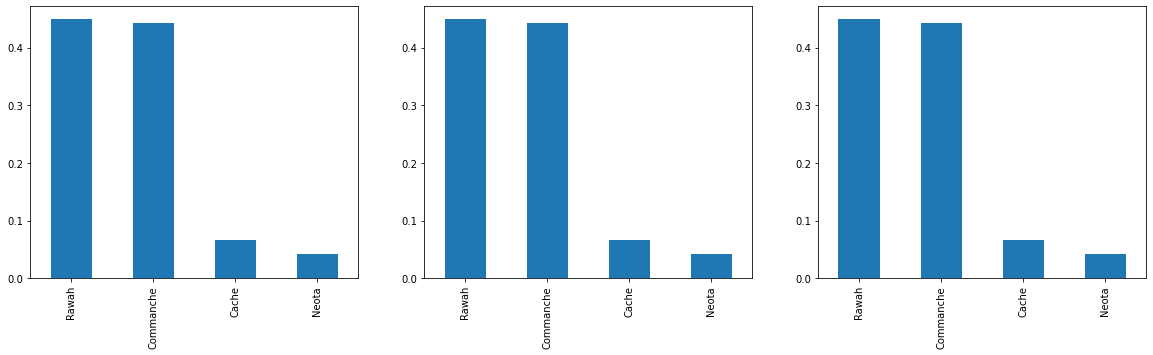

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[i])

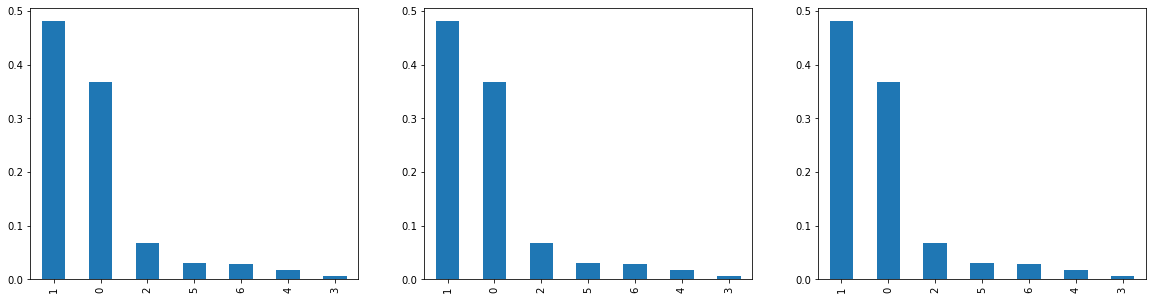

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[i])

In [15]:
serving_data['2020-04-01'] = normal_days_data_list[0]
serving_data['2020-04-02'] = normal_days_data_list[1]
serving_data['2020-04-03'] = normal_days_data_list[2]

## 4. Preparing Skewed Data
We are going to introduce the following skews to the data:
1. **Numerical Features**
  1. *Elevation - Feature Skew*: Convert the unit of measure from meters to kilometers in 2020-04-05
  2. *Aspect - Distribution Skew*: gradual decrease of the value

2. **Categorical Features**
  1. *Wilderness_Area - Feature Skew*: Adding a new category "Others" in 2020-04-05
  2. *Wilderness_Area - Distribution Skew*: Gradual increase of of the frequency of "Cache" and "Neota" values
3. **Target Features**: check the change of the distribution of predictied class labels

In [16]:
data_to_skew = data.sample(3000)
serving_data['2020-04-04'] = data_to_skew[:1000]
serving_data['2020-04-05'] = data_to_skew[1000:2000]
serving_data['2020-04-06'] = data_to_skew[2000:]

### 4.1 Skew numerical features

#### 4.1.1 Elevation Feature Skew

In [17]:
serving_data['2020-04-05']['Elevation'] = serving_data['2020-04-05']['Elevation'] / 1000

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


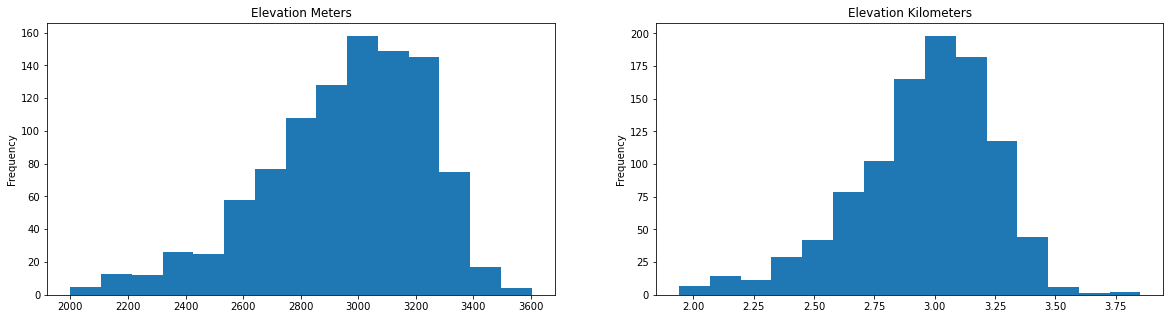

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
serving_data['2020-04-01']['Elevation'].plot.hist(bins=15, ax=axes[0], title='Elevation Meters')
serving_data['2020-04-05']['Elevation'].plot.hist(bins=15, ax=axes[1], title='Elevation Kilometers')

#### 4.1.2 Aspect Distribution Skew

In [19]:
serving_data['2020-04-04']['Aspect'] = serving_data['2020-04-04']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.90, 1) if value > 250 else value 
)

serving_data['2020-04-05']['Aspect'] = serving_data['2020-04-05']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.85, 1) if value > 250 else value 
)

serving_data['2020-04-06']['Aspect'] = serving_data['2020-04-06']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.80, 1) if value > 250 else value 
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

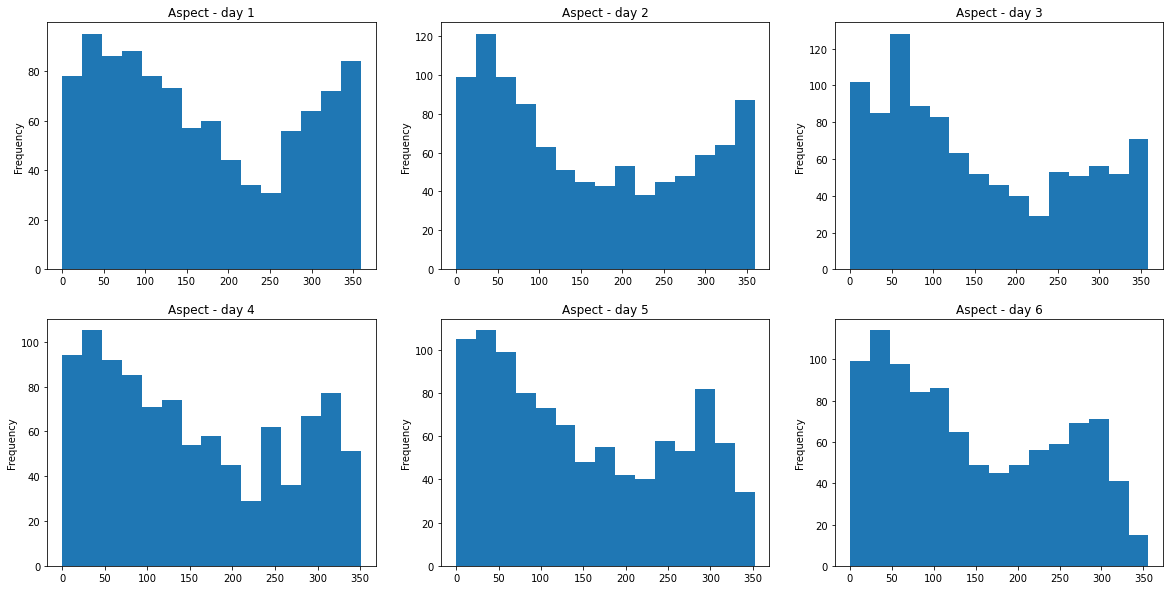

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Aspect'].plot.hist(bins=15, ax=axes[0, 0], title='Aspect - day 1')
serving_data['2020-04-02']['Aspect'].plot.hist(bins=15, ax=axes[0, 1], title='Aspect - day 2')
serving_data['2020-04-03']['Aspect'].plot.hist(bins=15, ax=axes[0, 2], title='Aspect - day 3')
serving_data['2020-04-04']['Aspect'].plot.hist(bins=15, ax=axes[1, 0], title='Aspect - day 4')
serving_data['2020-04-05']['Aspect'].plot.hist(bins=15, ax=axes[1, 1], title='Aspect - day 5')
serving_data['2020-04-06']['Aspect'].plot.hist(bins=15, ax=axes[1, 2], title='Aspect - day 6')

### 4.2 Skew categorical features

#### 4.2.1 Wilderness Area Feature Skew
Adding a new category "Others"


In [21]:
serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Others' if np.random.uniform() <= 0.1 else value
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


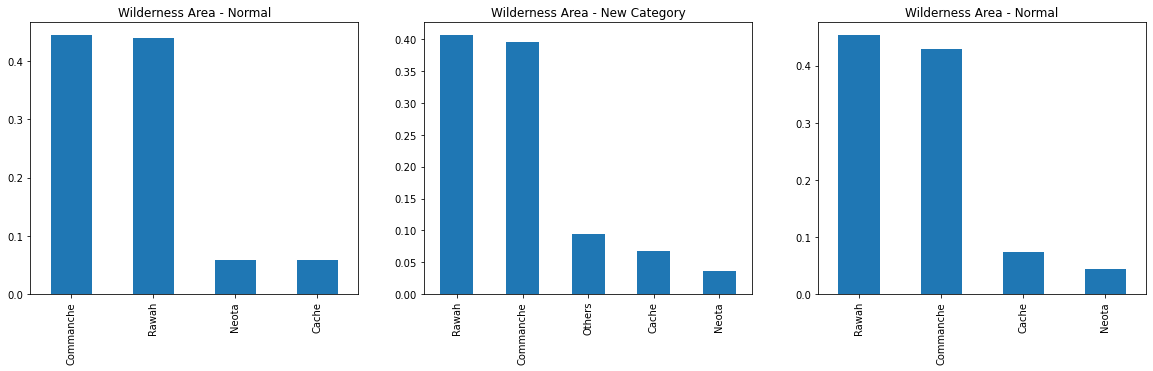

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0], title='Wilderness Area - Normal')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area - New Category')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[2], title='Wilderness Area - Normal')

#### 4.2.2 Wilderness Area Distribution Skew

In [23]:
serving_data['2020-04-04']['Wilderness_Area'] = serving_data['2020-04-04']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.1 else value
)

serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.15 else value
)

serving_data['2020-04-06']['Wilderness_Area'] = serving_data['2020-04-06']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.2 else value
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

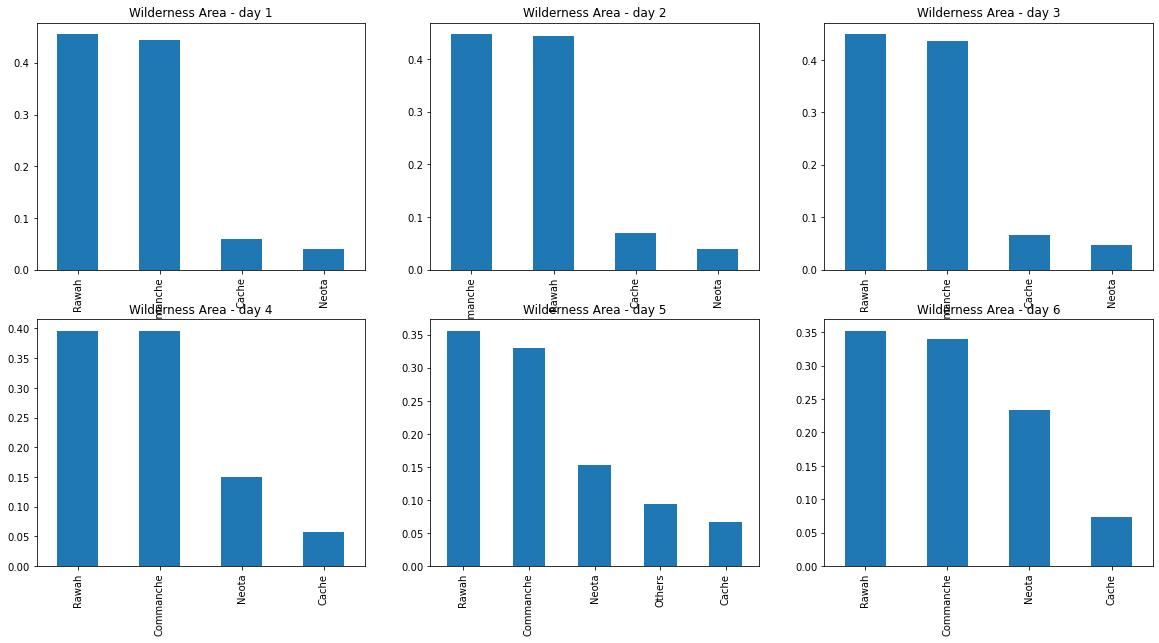

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 0], title='Wilderness Area - day 1')
serving_data['2020-04-02']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 1], title='Wilderness Area - day 2')
serving_data['2020-04-03']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 2], title='Wilderness Area - day 3')
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 0], title='Wilderness Area - day 4')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 1], title='Wilderness Area - day 5')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 2], title='Wilderness Area - day 6')


## 5. Simulating serving workload

### 5.1 Implement the model API client

In [25]:
import googleapiclient.discovery
import numpy as np

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print("Service name: {}".format(name))

def caip_predict(instances):
  
  serving_instances = []
  for instance in instances:
    serving_instances.append(
        {key: [value] for key, value in instance.items()})
    
  request_body={
      'signature_name': SIGNATURE_NAME,
      'instances': serving_instances}

  response = service.projects().predict(
      name=name,
      body=request_body

  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  probability_list = [output[MODEL_OUTPUT_KEY] for output in response['predictions']]
  classes = [FEATURE_LABELS[int(np.argmax(probabilities))] for probabilities in probability_list]
  return classes

Service name: projects/mlops-dev-env/models/covertype_classifier_tf/versions/v2


### 5.2 Prepare the request instances

In [26]:
def prepare_instances(serving_data):
  instances = []

  for request_timestamp, data in serving_data.items():
    for _, row in data.iterrows():
      instance = dict()
      for column_name in data.columns:
        if column_name == TARGET_FEATURE_NAME: continue
        instance[column_name] = str(row[column_name]) if column_name in CATEGORICAL_FEATURE_NAMES else row[column_name]
 #     instance['request_timestamp'] = request_timestamp
      instances.append(instance)

  return instances


In [27]:
import time

def simulate_requests():
  instances = prepare_instances(serving_data)

  print("Simulation started...")
  print("--------------------")
  print("Number of instances: {}".format(len(instances)))

  for i, instance in enumerate(instances):
    predicted_class = caip_predict([instance])
    print(".", end='')
    
    if (i + 1) % 100 == 0:
      print()
      print("Sent {} requests.".format(i + 1))

    #time.sleep(0.1)
  print("")
  print("--------------------")
  print("Simulation finised.")
    

In [28]:
simulate_requests()

Simulation started...
--------------------
Number of instances: 6000
....................................................................................................
Sent 100 requests.
....................................................................................................
Sent 200 requests.
....................................................................................................
Sent 300 requests.
....................................................................................................
Sent 400 requests.
....................................................................................................
Sent 500 requests.
....................................................................................................
Sent 600 requests.
....................................................................................................
Sent 700 requests.
...........................................................................................